## Consumption prediction 소비예측  

1. import & Data Check
2. EDA
3. Feature engineering
4. Modeling & submission

## 1. import & Data Check

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
os.listdir('./dataset/customer')

['sample_submission.csv', 'test.csv', 'train.csv']

In [3]:
df_train = pd.read_csv('./dataset/customer/train.csv')
df_test = pd.read_csv('./dataset/customer/test.csv')

### 1) 데이터 확인

In [4]:
df_train.columns, df_test.columns

(Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'target'],
       dtype='object'),
 Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'],
       dtype='object'))

In [5]:
df_train.head() # 22개의 컬럼

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


In [7]:
df_train.shape, df_test.shape # 1108명의 고객 - 많지는 않음

((1108, 22), (1108, 21))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

먼저 numerical 변수와 categorical 변수로 나눌게여
kidhome, teenhome : 고객 가구의 자녀 수, 고객 가구의 청소년 수 는
numerical으로 분류하였음! 

In [9]:
# numeric 과 categorical 변수로 나누기
# numeric 에는 target 제외함

numerical_features =df_train[['id', 'Year_Birth', 'Income', 'Kidhome',
        'Teenhome','Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth']].dtypes.index
print("numerical features : ",len(numerical_features))

categorical_features =df_train[['Education', 'Marital_Status', 'Dt_Customer','AcceptedCmp3',
                               'AcceptedCmp4', 'AcceptedCmp5',
                               'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']].dtypes.index
print("categorical features : ",len(categorical_features))

numerical features :  11
categorical features :  10


In [10]:
numerical_features

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object')

### 2) 이상치 탐색 및 제거
numerical 기준으로 확인합니다 

In [11]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(df_train, 2,['id', 'Year_Birth', 'Income', 'Kidhome',
        'Teenhome','Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth'])

# target 변수는 제외하고 돌리는게 포인트여요

In [12]:
df_train.loc[Outlier_to_drop]
# 이상치 없음!

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target


### 3) 결측 데이터 확인

In [13]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)
    
# 결측 데이터도 하나도 없음! 

column:         id	 Percent of NaN value: 0.00%
column: Year_Birth	 Percent of NaN value: 0.00%
column:  Education	 Percent of NaN value: 0.00%
column: Marital_Status	 Percent of NaN value: 0.00%
column:     Income	 Percent of NaN value: 0.00%
column:    Kidhome	 Percent of NaN value: 0.00%
column:   Teenhome	 Percent of NaN value: 0.00%
column: Dt_Customer	 Percent of NaN value: 0.00%
column:    Recency	 Percent of NaN value: 0.00%
column: NumDealsPurchases	 Percent of NaN value: 0.00%
column: NumWebPurchases	 Percent of NaN value: 0.00%
column: NumCatalogPurchases	 Percent of NaN value: 0.00%
column: NumStorePurchases	 Percent of NaN value: 0.00%
column: NumWebVisitsMonth	 Percent of NaN value: 0.00%
column: AcceptedCmp3	 Percent of NaN value: 0.00%
column: AcceptedCmp4	 Percent of NaN value: 0.00%
column: AcceptedCmp5	 Percent of NaN value: 0.00%
column: AcceptedCmp1	 Percent of NaN value: 0.00%
column: AcceptedCmp2	 Percent of NaN value: 0.00%
column:   Complain	 Percent of NaN val

In [14]:
# test 데이터도 확인

for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column:         id	 Percent of NaN value: 0.00%
column: Year_Birth	 Percent of NaN value: 0.00%
column:  Education	 Percent of NaN value: 0.00%
column: Marital_Status	 Percent of NaN value: 0.00%
column:     Income	 Percent of NaN value: 0.00%
column:    Kidhome	 Percent of NaN value: 0.00%
column:   Teenhome	 Percent of NaN value: 0.00%
column: Dt_Customer	 Percent of NaN value: 0.00%
column:    Recency	 Percent of NaN value: 0.00%
column: NumDealsPurchases	 Percent of NaN value: 0.00%
column: NumWebPurchases	 Percent of NaN value: 0.00%
column: NumCatalogPurchases	 Percent of NaN value: 0.00%
column: NumStorePurchases	 Percent of NaN value: 0.00%
column: NumWebVisitsMonth	 Percent of NaN value: 0.00%
column: AcceptedCmp3	 Percent of NaN value: 0.00%
column: AcceptedCmp4	 Percent of NaN value: 0.00%
column: AcceptedCmp5	 Percent of NaN value: 0.00%
column: AcceptedCmp1	 Percent of NaN value: 0.00%
column: AcceptedCmp2	 Percent of NaN value: 0.00%
column:   Complain	 Percent of NaN val

### 4) 비대칭성 확인 
- numerical 기준으로 

In [15]:
numerical_features # 10개의 변수들 (target 제외하였음)

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object')

In [16]:
for col in numerical_features:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ', 
         'Kurtosis : {:06.2f}'.format(df_train[col].kurt()),)

id              Skewness : 00.00    Kurtosis : -01.20
Year_Birth      Skewness : -0.44    Kurtosis : 001.19
Income          Skewness : 00.29    Kurtosis : 000.60
Kidhome         Skewness : 00.77    Kurtosis : -00.52
Teenhome        Skewness : 00.44    Kurtosis : -00.90
Recency         Skewness : -0.06    Kurtosis : -01.21
NumDealsPurchases Skewness : 02.26    Kurtosis : 007.73
NumWebPurchases Skewness : 01.29    Kurtosis : 004.92
NumCatalogPurchases Skewness : 01.10    Kurtosis : 000.38
NumStorePurchases Skewness : 00.65    Kurtosis : -00.76
NumWebVisitsMonth Skewness : 00.30    Kurtosis : 002.35


## 2. EDA

### 1) Numerical Feature  

수치형 데이터들을 알아보기 위한 plot

In [17]:
numerical_features

Index(['id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object')

### 그림 갈겨서 확인해보자고

In [18]:
corr_data = df_train[['target','Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth']]
# target이랑 가장 연관있는 순서대로 cols에 저장하고 heatmap 그림
# id는 필요없어서 뺌

k = 11
cols = corr_data.corr().nlargest(k, 'target')['target'].index
print(cols)

Index(['target', 'NumCatalogPurchases', 'Income', 'NumStorePurchases',
       'NumWebPurchases', 'Recency', 'NumDealsPurchases', 'Teenhome',
       'Year_Birth', 'NumWebVisitsMonth', 'Kidhome'],
      dtype='object')


<AxesSubplot:title={'center':'Correlation of Numeric Features with Consumption data'}>

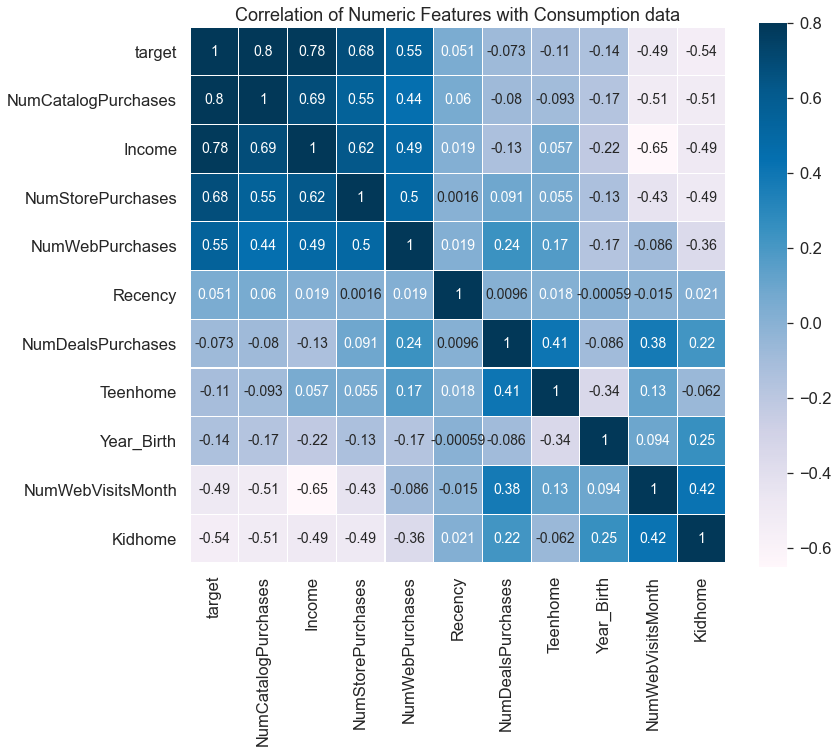

In [19]:
corr_data = df_train[['target', 'NumCatalogPurchases', 'Income', 'NumStorePurchases',
       'NumWebPurchases', 'Recency', 'NumDealsPurchases', 'Teenhome',
       'Year_Birth', 'NumWebVisitsMonth', 'Kidhome']]

colormap = plt.cm.PuBu
f , ax = plt.subplots(figsize = (12,10)) 
plt.title('Correlation of Numeric Features with Consumption data',y=1,size=18) 
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap, 
            linecolor="white",annot_kws = {'size':14})

'NumCatalogPurchases' : 카탈로그를 사용한 구매 수 

'Income' : 고객 연간 가구 소득 

'NumStorePurchases' : 매장에서 직접 구매한 횟수  


**0.6을 넘어 직접적으로 상관성이 있다고 판단되는 변수들의 정보**

### pair plot

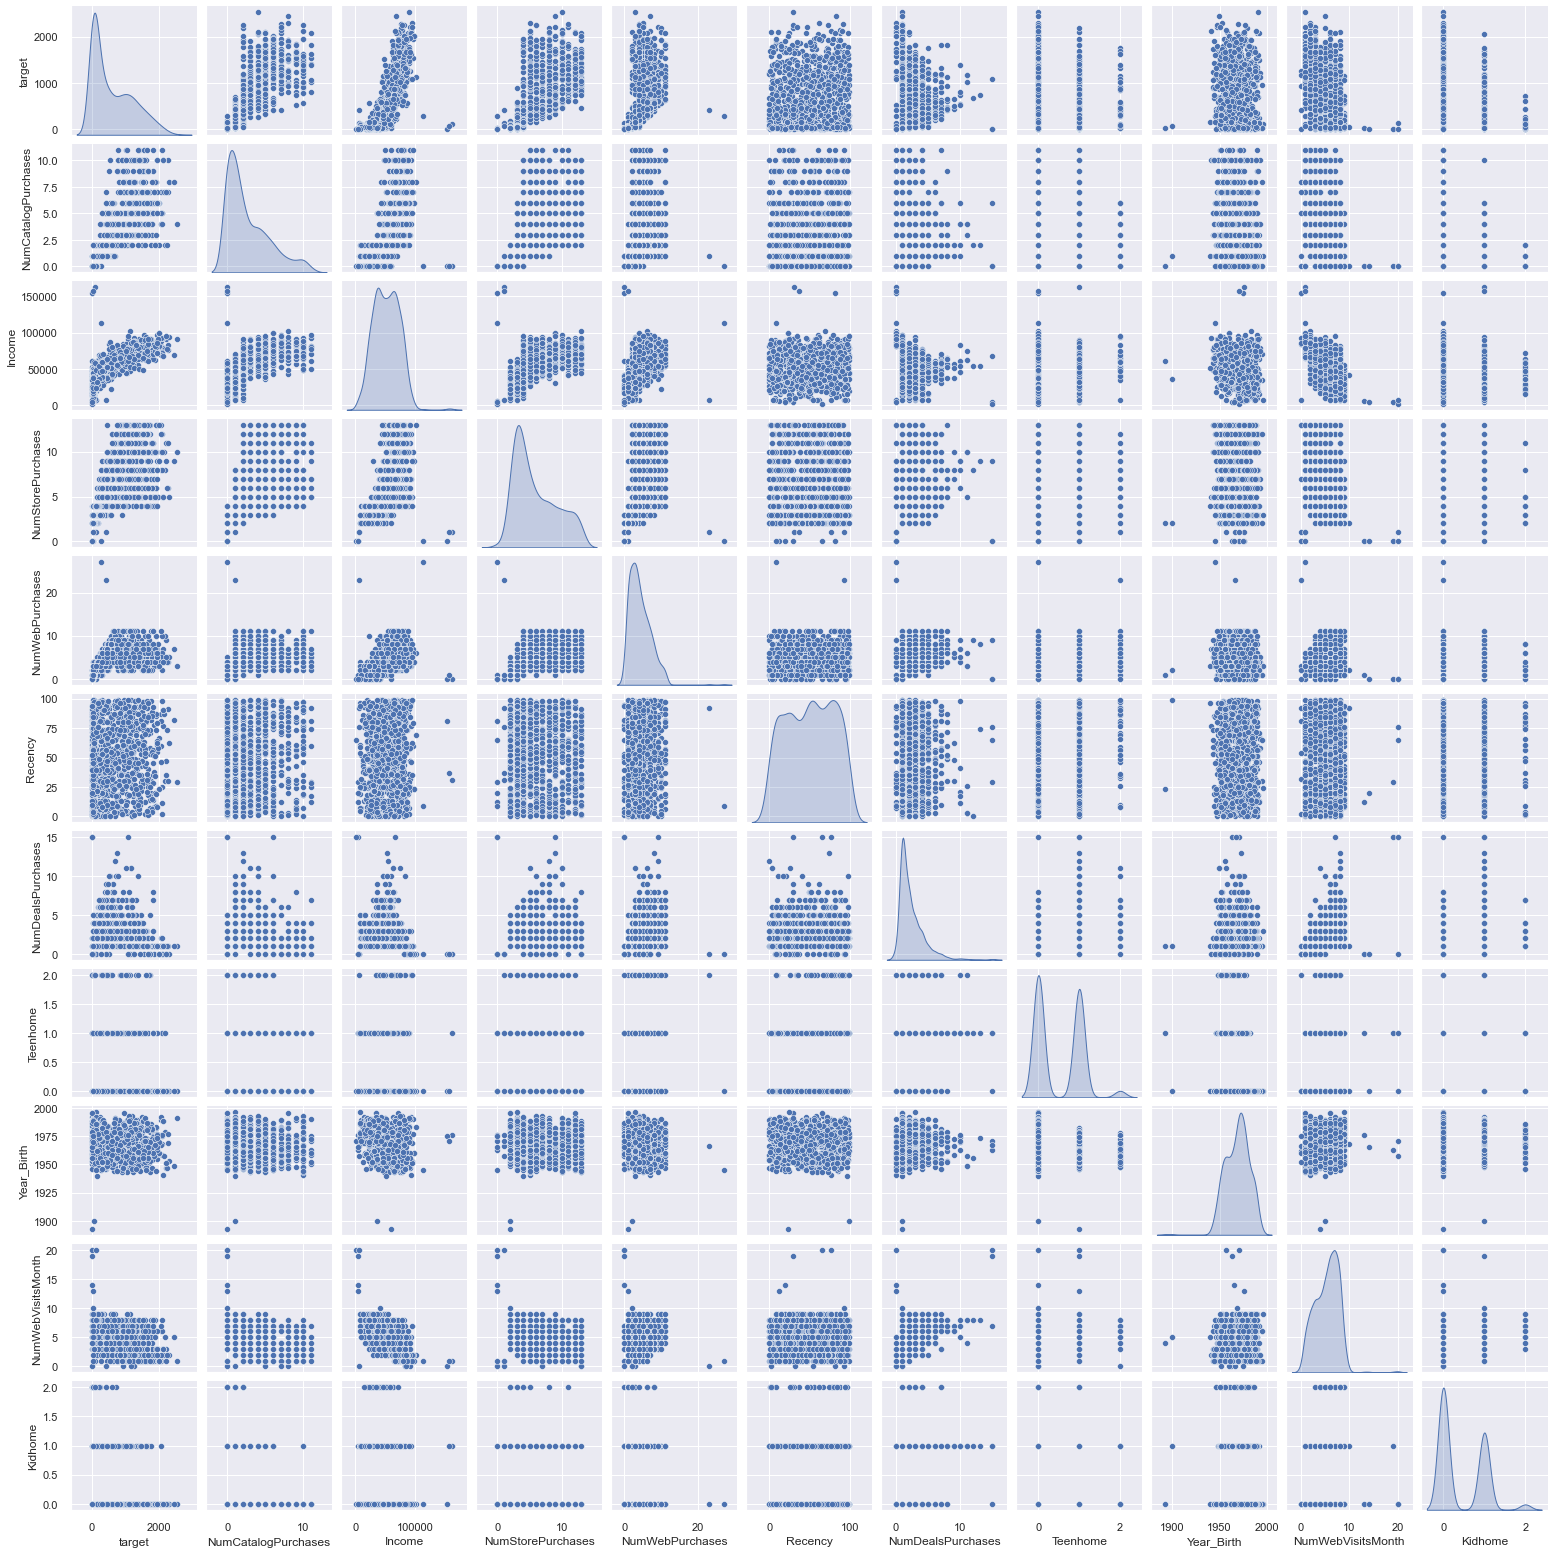

In [20]:
sns.set()
columns = ['target', 'NumCatalogPurchases', 'Income', 'NumStorePurchases',
       'NumWebPurchases', 'Recency', 'NumDealsPurchases', 'Teenhome',
       'Year_Birth', 'NumWebVisitsMonth', 'Kidhome']
sns.pairplot(df_train[columns],size = 2 ,kind ='scatter',diag_kind='kde') 
plt.show()

Kidhome, teenhome은 범주형 데이터의 형태를 띈다고도 할 수 있을듯

### 2) Categorical Feature

In [21]:
categorical_features
# 10개 

Index(['Education', 'Marital_Status', 'Dt_Customer', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response'],
      dtype='object')

In [22]:
# 범주형 변수들과 범주들을 확인
for catg in list(categorical_features):
    print(df_train[catg].value_counts())
    print('*'*50)

# 수락한 경우 1, 거절한 경우 0

Graduation    570
PhD           254
Master        173
2n Cycle       89
Basic          22
Name: Education, dtype: int64
**************************************************
Married     415
Together    296
Single      234
Divorced    120
Widow        39
Alone         2
YOLO          1
Absurd        1
Name: Marital_Status, dtype: int64
**************************************************
28-10-2013    7
03-06-2013    7
20-08-2013    6
10-01-2013    6
31-08-2012    6
             ..
18-03-2014    1
17-12-2013    1
09-01-2014    1
24-05-2013    1
06-11-2012    1
Name: Dt_Customer, Length: 536, dtype: int64
**************************************************
0    1031
1      77
Name: AcceptedCmp3, dtype: int64
**************************************************
0    1013
1      95
Name: AcceptedCmp4, dtype: int64
**************************************************
0    1028
1      80
Name: AcceptedCmp5, dtype: int64
**************************************************
0    1032
1      76
Name: Accep

막대그래프, 상자그림을 통해서 형태를 좀 찾아보자

상자그림 보다는 막대그래프가 더 보기 쉬울 것 같음
countplot을 그려서 그림으로 확인하면 이렇게 됨

<!-- df_train["Education"].value_counts().plot(kind="bar") -->

<AxesSubplot:xlabel='Response', ylabel='count'>

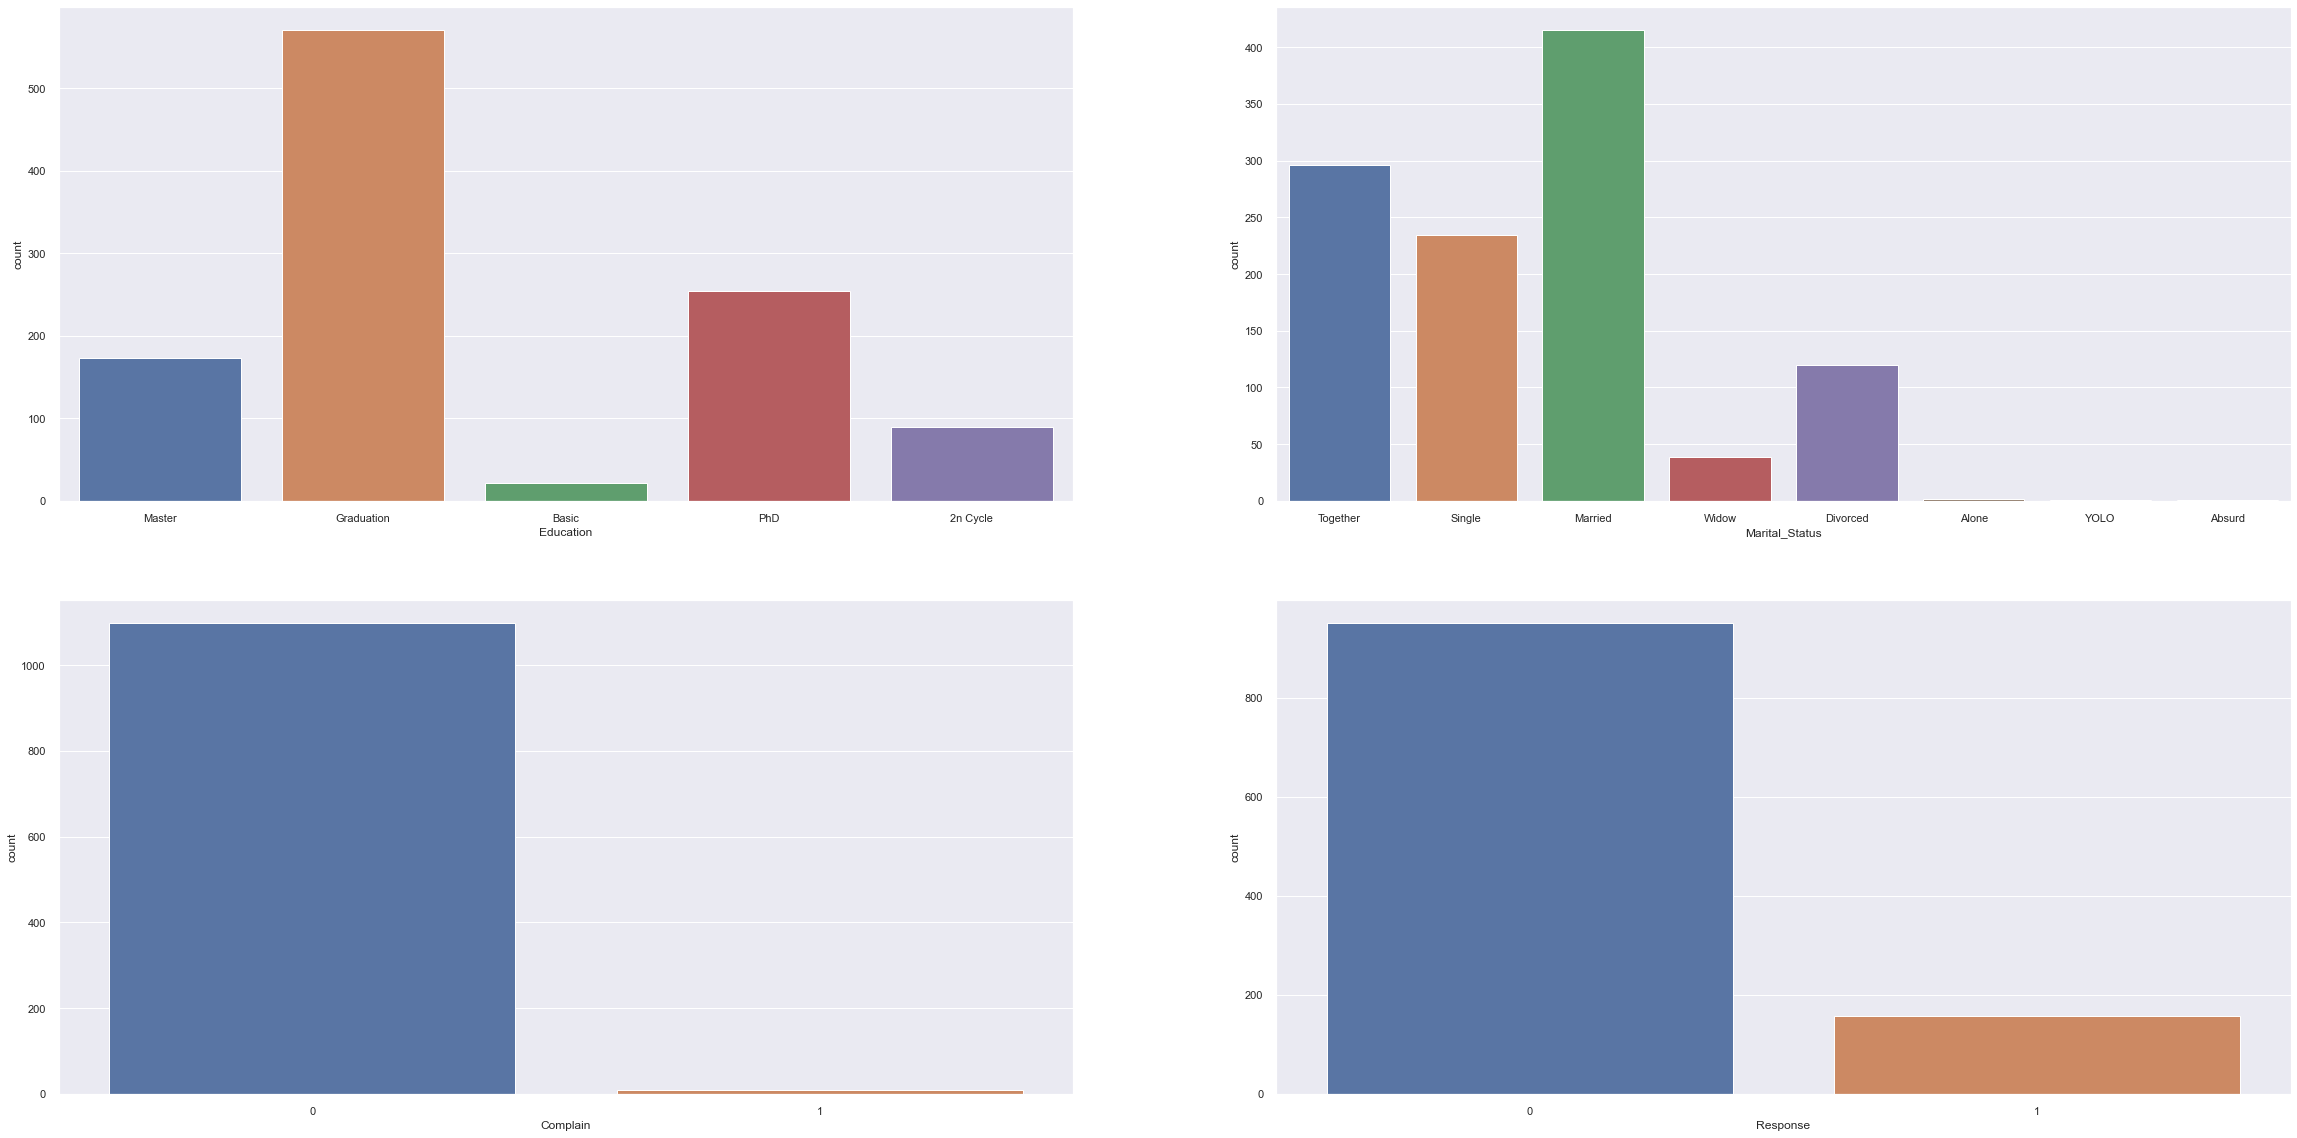

In [23]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2) 
figure.set_size_inches(40,20)

sns.countplot(data=df_train, x = "Education", ax = ax1)
sns.countplot(data=df_train, x = 'Marital_Status', ax = ax2) 
sns.countplot(data=df_train, x = 'Complain',ax = ax3) 
sns.countplot(data=df_train, x = 'Response',ax = ax4) 

#### Dt_Customer 분리하기
- EDA로 고객 정보 좀 확인하고 싶은 나의 마음

In [24]:
df_train['Dt_Customer']

0       21-01-2013
1       24-05-2014
2       08-04-2013
3       29-03-2014
4       10-06-2014
           ...    
1103    31-03-2013
1104    21-10-2013
1105    16-12-2013
1106    30-05-2013
1107    29-10-2012
Name: Dt_Customer, Length: 1108, dtype: object

In [25]:
df_train['Dt_Customer'] = pd.to_datetime(df_train['Dt_Customer'], format='%d-%m-%Y')
df_train['Dt_Customer']

0      2013-01-21
1      2014-05-24
2      2013-04-08
3      2014-03-29
4      2014-06-10
          ...    
1103   2013-03-31
1104   2013-10-21
1105   2013-12-16
1106   2013-05-30
1107   2012-10-29
Name: Dt_Customer, Length: 1108, dtype: datetime64[ns]

In [26]:
df_train['year'] = df_train['Dt_Customer'].dt.year
df_train['month'] = df_train['Dt_Customer'].dt.month
df_train['day'] = df_train['Dt_Customer'].dt.day

df_train

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,2013-01-21,21,10,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,2014-05-24,68,1,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,2013-04-08,50,2,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,2014-03-29,2,2,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,2014-06-10,56,7,...,0,0,1,0,0,0,444,2014,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1103,1956,Graduation,Together,46097.0,0,1,2013-03-31,11,5,...,0,0,0,0,0,0,241,2013,3,31
1104,1104,1986,Graduation,Married,23477.0,1,0,2013-10-21,39,3,...,0,0,0,0,0,0,147,2013,10,21
1105,1105,1975,Master,Married,37368.0,1,0,2013-12-16,4,1,...,0,0,0,0,0,0,30,2013,12,16
1106,1106,1974,Graduation,Divorced,53034.0,1,1,2013-05-30,30,8,...,0,0,0,0,0,0,447,2013,5,30


In [27]:
# test 데이터에 대해서도 처리
df_test['Dt_Customer'] = pd.to_datetime(df_test['Dt_Customer'], format='%d-%m-%Y')

In [28]:
df_test['year'] = df_test['Dt_Customer'].dt.year
df_test['month'] = df_test['Dt_Customer'].dt.month
df_test['day'] = df_test['Dt_Customer'].dt.day

In [29]:
df_test # 24개 완

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,0,1979,Graduation,Single,57537.0,1,0,2013-06-10,83,4,...,0,0,0,0,0,0,0,2013,6,10
1,1,1955,Graduation,Together,65748.0,0,1,2013-04-15,58,2,...,0,0,0,0,0,1,0,2013,4,15
2,2,1984,Graduation,Married,55434.0,1,0,2013-10-05,21,3,...,0,0,0,0,0,0,0,2013,10,5
3,3,1960,Graduation,Married,67716.0,0,1,2013-01-10,8,4,...,0,1,0,0,0,0,0,2013,1,10
4,4,1976,Graduation,Together,85606.0,0,1,2012-11-12,89,2,...,0,0,0,1,0,0,0,2012,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1103,1952,Graduation,Married,35704.0,1,1,2014-01-03,54,3,...,0,0,0,0,0,0,0,2014,1,3
1104,1104,1969,Master,Together,35924.0,1,1,2014-03-23,56,1,...,0,0,0,0,0,0,0,2014,3,23
1105,1105,1989,PhD,Single,33996.0,0,0,2013-09-11,46,1,...,0,0,0,0,0,0,0,2013,9,11
1106,1106,1970,Graduation,Together,74854.0,1,2,2013-04-08,90,7,...,0,0,0,0,0,0,0,2013,4,8


<AxesSubplot:xlabel='month', ylabel='target'>

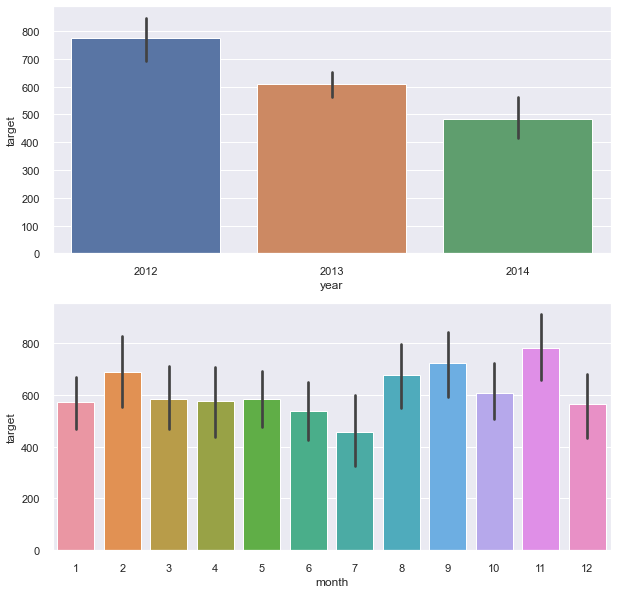

In [30]:
fig, (ax1,ax2) = plt.subplots(nrows = 2) 
fig.set_size_inches(10,10) 
sns.barplot(data=df_train, x = "year", y = "target", ax =ax1)  # 이전에 가입했을수록 소비가 커짐
sns.barplot(data=df_train, x = "month", y = "target", ax =ax2)

In [31]:
df_train['year']

0       2013
1       2014
2       2013
3       2014
4       2014
        ... 
1103    2013
1104    2013
1105    2013
1106    2013
1107    2012
Name: year, Length: 1108, dtype: int64

In [32]:
# year, month, day와의 상관관계 확인 - 수치형이 될 수도 있기 때문임

print(np.corrcoef(df_train['year'], df_train['target']), '\n')
print(np.corrcoef(df_train['month'], df_train['target']), '\n')
print(np.corrcoef(df_train['day'], df_train['target']))

# 유의하지는 않음

[[ 1.         -0.15940385]
 [-0.15940385  1.        ]] 

[[1.         0.03764911]
 [0.03764911 1.        ]] 

[[1.         0.01891694]
 [0.01891694 1.        ]]


In [33]:
# 캠페인과 상관관계도 확인 - 나중에 수치형으로 합칠거라서

df_train[['Year_Birth', 'AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'Response','target']].corr()

,Year_Birth,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,target
Year_Birth,1.000000,-0.050053,-0.034204,0.066802,-0.111485,-0.010873,-0.012304,-0.136035
AcceptedCmp1,-0.050053,1.000000,0.198530,0.052213,0.184717,0.379563,0.268577,0.361102
AcceptedCmp2,-0.034204,0.198530,1.000000,0.052513,0.328941,0.192139,0.201945,0.129995
AcceptedCmp3,0.066802,0.052213,0.052513,1.000000,-0.083690,0.060890,0.194275,0.040736
AcceptedCmp4,-0.111485,0.184717,0.328941,-0.083690,1.000000,0.313120,0.189849,0.256784
AcceptedCmp5,-0.010873,0.379563,0.192139,0.060890,0.313120,1.000000,0.336610,0.458208
Response,-0.012304,0.268577,0.201945,0.194275,0.189849,0.336610,1.000000,0.242760
target,-0.136035,0.361102,0.129995,0.040736,0.256784,0.458208,0.242760,1.000000


## 3. Feature Engineering 

- 비대칭성 처리
- 결측치 처리 -> 없음

- 변수 처리 (Dt_customer, acceptedCmp, Response)
- Categorical 변수의 수치화
- 유의하지 않은 변수 삭제

### 비대칭성 처리

Skewness: 0.817893
Kurtosis: -0.445411


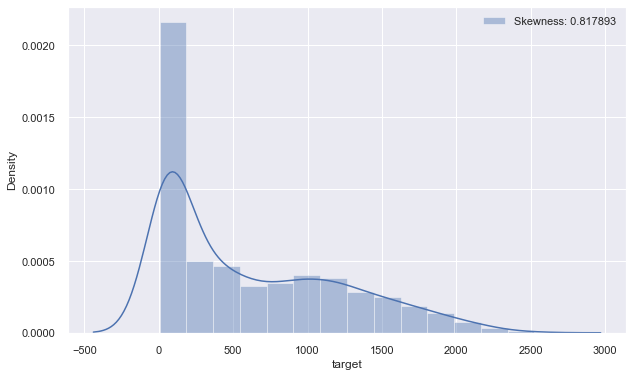

In [34]:
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["target"], color = "b", label="Skewness: {:2f}".format(df_train["target"].skew()), ax=ax) 
g = g.legend(loc = "best") 
print("Skewness: %f" % df_train["target"].skew()) 
print("Kurtosis: %f" % df_train["target"].kurt())

# 처리 안할게요

In [86]:
# # target 변수에 대해서 로그 변환
# df_train["target_Log"] = df_train["target"].map(lambda i:np.log(i) if i>0 else 0) 

# # 그림으로 확인해보자
# f, ax = plt.subplots(1, 1, figsize = (10,6)) 
# g = sns.distplot(df_train["target_Log"], color = "b", 
#                  label="Skewness: {:2f}".format(df_train["target_Log"].skew()), ax=ax) 
# g = g.legend(loc = "best") 

# # 수치도 알려줘
# print("Skewness: %f" % df_train['target_Log'].skew()) 
# print("Kurtosis: %f" % df_train['target_Log'].kurt()) 

# # 기존 count 변수 삭제
# df_train.drop('target', axis= 1, inplace=True)

1. Dt_Customer 변수를 사용해서 가입하고 얼마나 시간이 지났는지의 데이터로 수치형 변환 해줍니다
2. Year_Birth를 나이로 환산할 것이여요
3. Accepted(1~5)와 Response 변수로 새로운 feature를 생성

### 1) Dt_Customer

In [35]:
print(f'Minimum date: {df_train["Dt_Customer"].min()}')
print(f'Maximum date: {df_train["Dt_Customer"].max()}')

Minimum date: 2012-07-31 00:00:00
Maximum date: 2014-06-29 00:00:00


In [36]:
train_diff_date = df_train["Dt_Customer"] - df_train["Dt_Customer"].min()
test_diff_date = df_test["Dt_Customer"] - df_test["Dt_Customer"].min()

df_train["Pass_Customer"] = [i.days for i in train_diff_date]
df_test["Pass_Customer"] = [i.days for i in test_diff_date]

In [37]:
df_train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day,Pass_Customer
0,0,1974,Master,Together,46014.0,1,1,2013-01-21,21,10,...,0,0,0,0,0,541,2013,1,21,174
1,1,1962,Graduation,Single,76624.0,0,1,2014-05-24,68,1,...,0,0,0,0,0,899,2014,5,24,662
2,2,1951,Graduation,Married,75903.0,0,1,2013-04-08,50,2,...,0,0,0,0,0,901,2013,4,8,251
3,3,1974,Basic,Married,18393.0,1,0,2014-03-29,2,2,...,0,0,0,0,0,50,2014,3,29,606
4,4,1946,PhD,Together,64014.0,2,1,2014-06-10,56,7,...,0,1,0,0,0,444,2014,6,10,679


### 2) Year_Birth

In [38]:
print("Minimum birth :", df_train["Year_Birth"].min())
print("Maximum birth :", df_train["Year_Birth"].max())
df_train["Year_Birth"].head()

Minimum birth : 1893
Maximum birth : 1996


0    1974
1    1962
2    1951
3    1974
4    1946
Name: Year_Birth, dtype: int64

In [39]:
df_train["Age"] = 2022 - df_train["Year_Birth"]
df_test["Age"] = 2022 - df_test["Year_Birth"]

df_train["Age"].head()

0    48
1    60
2    71
3    48
4    76
Name: Age, dtype: int64

### 3) Accepted, Response

In [40]:
df_train["AcceptCount"] = df_train["AcceptedCmp1"] + df_train["AcceptedCmp2"] + df_train["AcceptedCmp3"] + df_train["AcceptedCmp4"] + df_train["AcceptedCmp5"] + df_train["Response"]
df_test["AcceptCount"] = df_test["AcceptedCmp1"] + df_test["AcceptedCmp2"] + df_test["AcceptedCmp3"] + df_test["AcceptedCmp4"] + df_test["AcceptedCmp5"] + df_test["Response"]

df_train["AcceptCount"].head()

0    0
1    1
2    0
3    0
4    1
Name: AcceptCount, dtype: int64

In [41]:
# 확인 한 번 갈겨 봅니다
print("Minimum count :", df_train["AcceptCount"].min(), "\nMaximum count :", df_train["AcceptCount"].max(), "\n")

# 6번 모두 수락한 경우는 없네요

Minimum count : 0 
Maximum count : 5 



In [42]:
df_train[['Pass_Customer', 'Age', 'AcceptCount', 'target']].corr()

,Pass_Customer,Age,AcceptCount,target
Pass_Customer,1.000000,0.012309,-0.080152,-0.174969
Age,0.012309,1.000000,0.043180,0.136035
AcceptCount,-0.080152,0.043180,1.000000,0.444114
target,-0.174969,0.136035,0.444114,1.000000


### 유의하지 않은 변수 제거

In [43]:
df_train.columns, df_test.columns

(Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'target',
        'year', 'month', 'day', 'Pass_Customer', 'Age', 'AcceptCount'],
       dtype='object'),
 Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'year', 'month',
        'day', 'Pass_Customer', 'Age', 'AcceptCount'],
       dtype='object'))

In [45]:
drop_col = ['Dt_Customer', 'Year_Birth', 'year', 'month', 'day',
            'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df_train = df_train.drop(drop_col, axis = 1)
df_test = df_test.drop(drop_col, axis = 1)

In [46]:
df_train.head()

,id,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,target,Pass_Customer,Age,AcceptCount
0,0,Master,Together,46014.0,1,1,21,10,7,1,8,7,0,541,174,48,0
1,1,Graduation,Single,76624.0,0,1,68,1,5,10,7,1,0,899,662,60,1
2,2,Graduation,Married,75903.0,0,1,50,2,6,6,9,3,0,901,251,71,0
3,3,Basic,Married,18393.0,1,0,2,2,3,0,3,8,0,50,606,48,0
4,4,PhD,Together,64014.0,2,1,56,7,8,2,5,7,0,444,679,76,1


### Categorical 변수의 수치화

- One-hot encoding 방법을 사용했지만 너무 세세하게 나뉘는 것 보다 
같다고 말할 수 있는 것은 같다고 묶어서 확인할 수도 있음!


#### Education, Marital_Status 라벨링
- One hot encoding 할거여

In [47]:
print(df_train['Education'].unique())
print(df_train['Marital_Status'].unique())

['Master' 'Graduation' 'Basic' 'PhD' '2n Cycle']
['Together' 'Single' 'Married' 'Widow' 'Divorced' 'Alone' 'YOLO' 'Absurd']


In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Education            1108 non-null   object 
 2   Marital_Status       1108 non-null   object 
 3   Income               1108 non-null   float64
 4   Kidhome              1108 non-null   int64  
 5   Teenhome             1108 non-null   int64  
 6   Recency              1108 non-null   int64  
 7   NumDealsPurchases    1108 non-null   int64  
 8   NumWebPurchases      1108 non-null   int64  
 9   NumCatalogPurchases  1108 non-null   int64  
 10  NumStorePurchases    1108 non-null   int64  
 11  NumWebVisitsMonth    1108 non-null   int64  
 12  Complain             1108 non-null   int64  
 13  target               1108 non-null   int64  
 14  Pass_Customer        1108 non-null   int64  
 15  Age                  1108 non-null   i

In [49]:
# One-hot encoding
# object에 대해서 자동으로 수행

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
print(df_train.columns)
print(df_test.columns)

Index(['id', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'target', 'Pass_Customer', 'Age',
       'AcceptCount', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')
Index(['id', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'Pass_Customer', 'Age', 'AcceptCount',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Absurd',
       'Marital_Status_Alon

In [50]:
print("Length of train column :", len(df_train.columns))
print("Length of test column :", len(df_test.columns))

Length of train column : 28
Length of test column : 27


In [51]:
df_train.head()

,id,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,0,46014.0,1,1,21,10,7,1,8,7,...,1,0,0,0,0,0,0,1,0,0
1,1,76624.0,0,1,68,1,5,10,7,1,...,0,0,0,0,0,0,1,0,0,0
2,2,75903.0,0,1,50,2,6,6,9,3,...,0,0,0,0,0,1,0,0,0,0
3,3,18393.0,1,0,2,2,3,0,3,8,...,0,0,0,0,0,1,0,0,0,0
4,4,64014.0,2,1,56,7,8,2,5,7,...,0,1,0,0,0,0,0,1,0,0


In [52]:
df_train.drop('id', axis = 1, inplace=True)
df_test.drop('id', axis = 1, inplace=True)

In [53]:
df_train.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'target', 'Pass_Customer', 'Age',
       'AcceptCount', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')

In [54]:
df_train.shape, df_test.shape

((1108, 27), (1108, 26))

변수들을 따로 나눠서 저장하기

1. 그 범주가 어떤 값을 가지는 지 확인하는 코드 있었는데 찾아보기
2. 분석 과정이 부드럽고 자연스럽게 이어지도록 수정
- 범주화하는 과정이 따로 있었던거 같은디?
- 그리고 datetime 으로 가입날짜 확인해서 시각화도 한 번 해보고
3. linear Regression이 적합할까? 아니면 로지스틱이 맞을까 생각해보기
4. 발생할 수 있는 DA분석 과정 꼭 정리해둘 것

## 4. Modeling & make submission

In [55]:
# 데이터 셋 분할
from sklearn.model_selection import train_test_split
from sklearn import metrics

# array여야 하기 때문에 꼭 변경 해야됨~~~!!!
X_train = df_train.drop('target', axis=1).values
target_label = df_train['target'].values
X_test = df_test.values

In [56]:
X_train.shape, target_label.shape, X_test.shape

((1108, 26), (1108,), (1108, 26))

### Modeling 

뭘 써야 할 까..... 앙상블 ?